# Information Extractor - Hybrid LangChain Pipeline

**Streamlined document extraction using YAML-configured LangChain v1.0 pipeline.**

**Key Features:**
- YAML-based configuration (no code changes needed)
- Hot-reload capability (edit prompts live)
- LangChain v1.0 (BaseChatModel with multi-modal messages)
- Easy model switching (Llama ↔ InternVL3)
- Comprehensive analytics and visualizations
- Production-ready validation and cleaning (81.8% accuracy)

## 1. Imports and Setup

In [1]:
# Enable autoreload for module changes
%load_ext autoreload
%autoreload 2

import os
os.environ['EVALUATION_METHOD'] = 'order_aware_f1'  # or 'f1', 'kieval', 'correlation'

# Standard library
import warnings
from datetime import datetime
from pathlib import Path

# Third-party
import numpy as np
import pandas as pd
from IPython.display import Image, display
from rich import print as rprint
from rich.console import Console

# LangChain Integration
from common.langchain_chains import create_pipeline
from common.langchain_llm import VisionLanguageModelFactory
from common.langchain_prompts import LangChainPromptManager

# Model loaders
from common.internvl3_model_loader import load_internvl3_model
from common.llama_model_loader import load_llama_model

# Utilities
from common.batch_analytics import BatchAnalytics
from common.batch_reporting import BatchReporter
from common.batch_visualizations import BatchVisualizer
from common.config import get_yaml_config
from common.evaluation_metrics import load_ground_truth
from common.extraction_parser import discover_images
from common.gpu_optimization import emergency_cleanup

console = Console()
warnings.filterwarnings('ignore')

rprint("[bold green]✅ Hybrid LangChain pipeline loaded successfully![/bold green]")
rprint("[cyan]📋 Configuration: config/models.yaml, config/prompts.yaml[/cyan]")

✅ Hybrid LangChain pipeline loaded successfully!

📋 Configuration: config/models.yaml, config/prompts.yaml

## 2. Pre-emptive Memory Cleanup

**CRITICAL for V100**: Clear GPU memory before loading models.

In [2]:
rprint("[bold red]🧹 PRE-EMPTIVE GPU MEMORY CLEANUP[/bold red]")
rprint("[yellow]Clearing any existing model caches...[/yellow]")

emergency_cleanup(verbose=True)

rprint("[green]✅ Memory cleanup complete - ready for model loading[/green]")

🧹 PRE-EMPTIVE GPU MEMORY CLEANUP

Clearing any existing model caches...

🚨 Running V100 emergency GPU cleanup...
🧹 Starting V100-optimized GPU memory cleanup...
   📊 Initial GPU memory: 0.00GB allocated, 0.00GB reserved
   ✅ Final GPU memory: 0.00GB allocated, 0.00GB reserved
   💾 Memory freed: 0.00GB
✅ V100-optimized memory cleanup complete
✅ V100 emergency cleanup complete


✅ Memory cleanup complete - ready for model loading

## 3. Configuration

**Easy model switching**: Change `MODEL_NAME` to any model from `config/models.yaml`.

In [ ]:
# ============================================================================
# MODEL SELECTION - Change this to switch models!
# ============================================================================
# Available models (from config/models.yaml):
#   - "llama-3.2-11b-vision"         (full precision, best quality)
#   - "llama-3.2-11b-vision-8bit"    (8-bit quantized, memory efficient)
#   - "internvl3-2b"                 (lightweight, fast)
#   - "internvl3-8b"                 (strong performance)
#   - "internvl3-8b-quantized"       (V100 compatible)
#   - "internvl3_5-8b"               (latest version, improved performance)
# ============================================================================

CONFIG = {
    # Model selection (loads from config/models.yaml)
    'MODEL_NAME': 'internvl3_5-8b',  # Change to switch models!
    
    # Prompt configuration (loads from config/prompts.yaml)
    'SYSTEM_MODE': 'expert',  # Options: expert, structured, precise, flexible, strict
    
    # Data paths
    'DATA_DIR': '/home/jovyan/nfs_share/tod/information_extractor_standalone/evaluation_data/images',  # UPDATE THIS PATH
    'GROUND_TRUTH': '/home/jovyan/nfs_share/tod/information_extractor_standalone/evaluation_data/ground_truth.csv',  # UPDATE THIS PATH
    'OUTPUT_BASE': './output',  # Output directory (relative to notebook location)
    
    # Batch settings
    'MAX_IMAGES': None,  # None for all images
    'DOCUMENT_TYPES': None,  # None for all types, or ['invoice', 'receipt']
    
    # Processing options
    'ENABLE_PREPROCESSING': True,  # Image preprocessing
    'PREPROCESSING_MODE': 'adaptive',  # light, moderate, aggressive, adaptive
    'ENABLE_FIXING': False,  # Self-healing parser (experimental)
    'ENABLE_MATH_ENHANCEMENT': False,  # Mathematical correction
    
    # Mode
    'INFERENCE_ONLY': False,  # True = no ground truth needed
    
    # Verbosity
    'VERBOSE': True,
}

# Adjust ground truth based on mode
if CONFIG['INFERENCE_ONLY']:
    CONFIG['GROUND_TRUTH'] = None

rprint("[bold green]✅ Configuration loaded[/bold green]")
rprint(f"[cyan]🤖 Model: {CONFIG['MODEL_NAME']}[/cyan]")
rprint(f"[cyan]💬 System Mode: {CONFIG['SYSTEM_MODE']}[/cyan]")
rprint(f"[cyan]📂 Data: {CONFIG['DATA_DIR']}[/cyan]")
mode_text = 'Inference-only' if CONFIG['INFERENCE_ONLY'] else 'Evaluation'
rprint(f"[cyan]🎯 Mode: {mode_text}[/cyan]")
preprocessing_text = f"Enabled ({CONFIG['PREPROCESSING_MODE']})" if CONFIG['ENABLE_PREPROCESSING'] else 'Disabled'
rprint(f"[cyan]🔧 Preprocessing: {preprocessing_text}[/cyan]")

## 4. Output Directory Setup

In [4]:
OUTPUT_BASE = Path(CONFIG['OUTPUT_BASE'])
if not OUTPUT_BASE.is_absolute():
    OUTPUT_BASE = Path.cwd() / OUTPUT_BASE

BATCH_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

OUTPUT_DIRS = {
    'base': OUTPUT_BASE,
    'batch': OUTPUT_BASE / 'batch_results',
    'csv': OUTPUT_BASE / 'csv',
    'visualizations': OUTPUT_BASE / 'visualizations',
    'reports': OUTPUT_BASE / 'reports'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

rprint(f"[green]✅ Output directories created: {OUTPUT_BASE}[/green]")

✅ Output directories created: /home/jovyan/nfs_share/tod/information_extractor_standalone/output

## 5. Load Model with YAML Configuration

**NEW**: Uses `VisionLanguageModelFactory` to load model from YAML config.

In [5]:
# Load YAML configuration
yaml_config = get_yaml_config()
model_config = yaml_config.get_model_config(CONFIG['MODEL_NAME'])

rprint(f"[bold cyan]Loading {model_config.model_id}...[/bold cyan]")
rprint(f"[cyan]  Max tokens: {model_config.max_new_tokens}[/cyan]")
rprint(f"[cyan]  Temperature: {model_config.temperature}[/cyan]")
rprint(f"[cyan]  Quantization: {model_config.use_quantization}[/cyan]")

# Select appropriate model loader based on model name
if 'llama' in CONFIG['MODEL_NAME'].lower():
    model_loader = load_llama_model
elif 'internvl' in CONFIG['MODEL_NAME'].lower():
    model_loader = load_internvl3_model
else:
    raise ValueError(f"Unknown model type: {CONFIG['MODEL_NAME']}")

# Create LangChain wrapper with YAML config
llm = VisionLanguageModelFactory.from_yaml_config(
    model_name=CONFIG['MODEL_NAME'],
    model_loader_func=model_loader,
    verbose=CONFIG['VERBOSE']
)

rprint("[bold green]✅ Vision-language model loaded with LangChain interface[/bold green]")
rprint(f"[cyan]Type: {llm._llm_type}[/cyan]")
rprint(f"[cyan]Model: {llm.model_id}[/cyan]")

✅ Configuration reloaded from /home/jovyan/nfs_share/tod/information_extractor_standalone/config


Loading /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct...

  Max tokens: 2048

  Temperature: 0.0

  Quantization: False

🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state (Multi-GPU Total): Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 2 GPU(s), analyzing each device...
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 2/2 GPUs detected
📊 Total Memory: 279.44GB
💾 Available Memory: 279.44GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: Yes
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)
   GPU 1 (NVIDIA H200): 139.7GB total, 139.7GB available (0.0% used)


📊 GPU Hardware: NVIDIA H200 (2x 140GB = 279GB total)

🏗️ Architecture: datacenter_high_memory (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (estimated need: 22GB + 6.0GB buffer)

💾 Available Memory: 279.4GB across 2 GPU(s)

💡 Memory sufficient: ✅ Yes

✅ datacenter_high_memory with 279GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 279GB

   Available Memory: 279GB

Model needs: ~22GB + 6.0GB buffer for Llama-3.2-11B-Vision

   Working GPUs: 2/2

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

🔄 Auto-distributing model across 2 GPUs...

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading processor...

✅ Model and processor loaded successfully!

🔄 Multi-GPU Distribution Analysis (2 GPUs):

GPU 0 (NVIDIA H200): 9.8GB/150GB (6.6%)

GPU 1 (NVIDIA H200): 11.6GB/150GB (7.8%)

📊 Total across all GPUs: 21.3GB allocated, 21.6GB reserved, 300GB capacity

✅ Model successfully distributed across GPUs

0: 18 modules

1: 28 modules

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cuda:0                        │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 4000                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 2x NVIDIA H200 (300GB)        │ ✅ 300GB Total                    │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state (Multi-GPU Total): Allocated=21.34GB, Reserved=21.65GB, Fragmentation=0.30GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Initialized VisionLanguageModel: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct
   Model type: Llama (chat template)


✅ Vision-language model loaded with LangChain interface

Type: vision_language_model

Model: /home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct

## 6. Create Processing Pipeline

**NEW**: Uses LangChain `DocumentProcessingPipeline` with YAML prompts.

In [6]:
# Create processing pipeline
pipeline = create_pipeline(
    llm=llm,
    enable_fixing=CONFIG['ENABLE_FIXING'],
    enable_cleaning=False,  # Disable automatic cleaning - we'll do it explicitly in a separate cell
    verbose=CONFIG['VERBOSE']
)

# Create prompt manager for hot-reload capability
prompt_manager = LangChainPromptManager(
    use_yaml_config=True,
    system_mode=CONFIG['SYSTEM_MODE']
)

rprint("[bold green]✅ Processing pipeline created[/bold green]")
rprint("[cyan]Features:[/cyan]")
rprint("  ✓ Document type detection")
rprint("  ✓ Field extraction with Pydantic validation")
rprint("  ✓ Cleaning disabled - will be done explicitly in separate cell")
rprint("  ✓ Hot-reload prompts: prompt_manager.reload_config()")

if CONFIG['ENABLE_FIXING']:
    rprint("  ✓ Self-healing parser enabled")

✅ Processing pipeline created

Features:

✓ Document type detection

✓ Field extraction with Pydantic validation

✓ Cleaning disabled - will be done explicitly in separate cell

✓ Hot-reload prompts: prompt_manager.reload_config()

## 7. Image Discovery and Preprocessing

In [7]:
# Discover images
data_dir = Path(CONFIG['DATA_DIR'])
if not data_dir.is_absolute():
    data_dir = Path.cwd() / data_dir

all_images = discover_images(str(data_dir))

# Image preprocessing (optional)
if CONFIG['ENABLE_PREPROCESSING']:
    import tempfile
    from common.image_preprocessing import (
        enhance_statement_quality,
        enhance_for_llama,
        preprocess_statement_for_llama,
        adaptive_enhance,
        preprocess_recommended
    )
    
    preprocess_functions = {
        'light': enhance_statement_quality,
        'moderate': enhance_for_llama,
        'aggressive': preprocess_statement_for_llama,
        'adaptive': adaptive_enhance,
        'recommended': preprocess_recommended
    }
    
    preprocess_fn = preprocess_functions[CONFIG['PREPROCESSING_MODE']]
    preprocessed_images = []
    preprocessed_dir = Path(tempfile.mkdtemp(prefix='preprocessed_'))
    
    rprint(f"[cyan]🔧 Preprocessing {len(all_images)} images ({CONFIG['PREPROCESSING_MODE']})[/cyan]")
    
    for img_path in all_images:
        try:
            preprocessed_img = preprocess_fn(img_path)
            preprocessed_path = preprocessed_dir / Path(img_path).name
            preprocessed_img.save(preprocessed_path)
            preprocessed_images.append(str(preprocessed_path))
        except Exception as e:
            rprint(f"[yellow]⚠️ Preprocessing failed for {Path(img_path).name}: {e}[/yellow]")
            preprocessed_images.append(img_path)
    
    all_images = preprocessed_images
    rprint(f"[green]✅ Preprocessing complete[/green]")

# Load ground truth
ground_truth = {}
if not CONFIG['INFERENCE_ONLY'] and CONFIG['GROUND_TRUTH']:
    ground_truth_path = Path(CONFIG['GROUND_TRUTH'])
    if not ground_truth_path.is_absolute():
        ground_truth_path = Path.cwd() / ground_truth_path
    
    ground_truth = load_ground_truth(str(ground_truth_path), verbose=CONFIG['VERBOSE'])
    rprint(f"[green]✅ Ground truth loaded for {len(ground_truth)} images[/green]")

# Apply filters
if CONFIG['DOCUMENT_TYPES'] and ground_truth:
    filtered = []
    for img in all_images:
        img_name = Path(img).name
        if img_name in ground_truth:
            doc_type = ground_truth[img_name].get('DOCUMENT_TYPE', '').lower()
            if any(dt.lower() in doc_type for dt in CONFIG['DOCUMENT_TYPES']):
                filtered.append(img)
    all_images = filtered

if CONFIG['MAX_IMAGES']:
    all_images = all_images[:CONFIG['MAX_IMAGES']]

rprint(f"[bold green]Ready to process {len(all_images)} images[/bold green]")
for i, img in enumerate(all_images[:5], 1):
    print(f"  {i}. {Path(img).name}")
if len(all_images) > 5:
    print(f"  ... and {len(all_images) - 5} more")

🔧 Preprocessing 9 images (adaptive)

✅ Preprocessing complete

📊 Ground truth CSV loaded with 9 rows and 20 columns
📋 Available columns: ['image_file', 'DOCUMENT_TYPE', 'BUSINESS_ABN', 'BUSINESS_ADDRESS', 'GST_AMOUNT', 'INVOICE_DATE', 'IS_GST_INCLUDED', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 'LINE_ITEM_TOTAL_PRICES', 'PAYER_ADDRESS', 'PAYER_NAME', 'STATEMENT_DATE_RANGE', 'SUPPLIER_NAME', 'TOTAL_AMOUNT', 'TRANSACTION_AMOUNTS_PAID', 'TRANSACTION_DATES', 'TRANSACTION_AMOUNTS_RECEIVED', 'ACCOUNT_BALANCE']
✅ Using 'image_file' as image identifier column
✅ Ground truth mapping created for 9 images


✅ Ground truth loaded for 9 images

Ready to process 9 images

  1. image_001.png
  2. image_002.png
  3. image_003.png
  4. image_004.png
  5. image_005.png
  ... and 4 more


## 8. Batch Processing with LangChain Pipeline

**NEW**: Uses `pipeline.process_batch()` with LangChain interface.

In [8]:
# Process batch using LangChain pipeline
rprint("[bold cyan]🚀 Starting batch processing...[/bold cyan]")

start_time = datetime.now()
batch_results = pipeline.process_batch(all_images)
end_time = datetime.now()

total_time = (end_time - start_time).total_seconds()
processing_times = [total_time / len(batch_results)] * len(batch_results)  # Estimate individual times

# Extract document types
document_types_found = {}
for result in batch_results:
    doc_type = result.get('document_type', 'unknown')
    document_types_found[doc_type] = document_types_found.get(doc_type, 0) + 1

# Summary
rprint(f"[bold green]✅ Processed {len(batch_results)} images in {total_time:.1f}s[/bold green]")
rprint(f"[cyan]Average time: {np.mean(processing_times):.2f}s per image[/cyan]")
rprint(f"[cyan]Document types found: {document_types_found}[/cyan]")

# Count successful vs failed
successful = len([r for r in batch_results if 'error' not in r])
failed = len(batch_results) - successful
rprint(f"[cyan]Success rate: {successful}/{len(batch_results)} ({successful/len(batch_results)*100:.1f}%)[/cyan]")
if failed > 0:
    rprint(f"[yellow]⚠️  {failed} documents had processing errors[/yellow]")

🚀 Starting batch processing...


🔄 Processing batch of 9 images

[1/9] 
Processing: image_001.png

📋 Step 1: Document Type Detection
🔍 Detecting document type: image_001.png
📄 Raw detection response: DOCUMENT_TYPE: RECEIPT...
✅ Detected type: receipt

📊 Step 2: Field Extraction (receipt)
📊 Extracting receipt fields: image_001.png
📄 Raw extraction response: DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 06 082 698 025
SUPPLIER_NAME: Liberty Oil
BUSINESS_ADDRESS: 481 Bourke Street, Perth WA 6000
PAYER_NAME: Robert Taylor
PAYER_ADDRESS: 243 Adelaide Street, Perth WA...
✅ Extracted 14 fields

✅ Processing complete!


[2/9] 
Processing: image_002.png

📋 Step 1: Document Type Detection
🔍 Detecting document type: image_002.png
📄 Raw detection response: DOCUMENT_TYPE: RECEIPT...
✅ Detected type: receipt

📊 Step 2: Field Extraction (receipt)
📊 Extracting receipt fields: image_002.png
📄 Raw extraction response: DOCUMENT_TYPE: RECEIPT
BUSINESS_ABN: 29 466 483 258
SUPPLIER_NAME: Ampol Limited
BUSINESS_ADDRESS: 680 Collins Street, Darwin N

✅ Processed 9 images in 101.9s

Average time: 11.32s per image

Document types found: {'receipt': 3, 'bank_statement': 3, 'invoice': 3}

Success rate: 9/9 (100.0%)

## 8.3. Clean and Normalize Extracted Data

**CRITICAL**: Apply ExtractionCleaner to normalize field values for accuracy.

This step transforms raw model output into clean, ground-truth-compatible format:
- **ABN**: `06082698025` → `06 082 698 025`
- **Monetary**: `$4,834.03` → `$4834.03` (remove commas)
- **Addresses**: Remove phone/email, normalize spacing
- **Dates**: `Thu 04 Sep 2025` → `04/09/2025`
- **Document types**: `STATEMENT` → `BANK_STATEMENT`
- **Lists**: Convert to pipe-separated format

**Expected impact**: Restores accuracy from ~49% → ~82% (81.8% baseline)

In [9]:
from decimal import Decimal

from common.extraction_cleaner import ExtractionCleaner


def serialize_pydantic_to_llm_format(field_name: str, value) -> str:
    """
    Convert Pydantic model types to LLM output format strings.
    
    This prepares types for ExtractionCleaner which expects LLM string output.
    """
    # Handle NOT_FOUND
    if value == "NOT_FOUND" or value is None:
        return "NOT_FOUND"
    
    # Handle lists - convert to comma-separated (cleaner will convert to pipes)
    if isinstance(value, list):
        if not value:
            return "NOT_FOUND"
        # Convert each item to string
        str_items = []
        for item in value:
            if isinstance(item, Decimal):
                str_items.append(f"${str(item)}")
            else:
                str_items.append(str(item))
        return ", ".join(str_items)
    
    # Handle Decimal - convert to string with $ for monetary fields
    if isinstance(value, Decimal):
        return f"${str(value)}"
    
    # Handle boolean - convert to lowercase string
    if isinstance(value, bool):
        return str(value).lower()
    
    # Everything else - just convert to string
    return str(value)


# Create cleaner instance
cleaner = ExtractionCleaner(debug=False)  # Set to True to see each field transformation

rprint("[bold cyan]🧹 Cleaning and normalizing extracted data...[/bold cyan]")

# Track cleaning statistics
cleaning_stats = {
    'documents_cleaned': 0,
    'total_fields_cleaned': 0,
    'cleaning_examples': []
}

# Clean each document's extracted data
for i, result in enumerate(batch_results):
    if 'extracted_data' not in result:
        continue
    
    extracted_data = result['extracted_data']
    
    # Convert Pydantic model to dict
    if hasattr(extracted_data, 'model_dump'):
        raw_dict = extracted_data.model_dump()
    elif hasattr(extracted_data, 'dict'):
        raw_dict = extracted_data.dict()
    else:
        continue  # Skip if not a Pydantic model
    
    # CRITICAL: Serialize Python types to LLM format strings
    # This converts Lists→strings, Decimals→"$123.45", bools→"true"/"false"
    serialized_dict = {
        field: serialize_pydantic_to_llm_format(field, value)
        for field, value in raw_dict.items()
    }
    
    # Clean all fields (now expects LLM string output)
    cleaned_dict = cleaner.clean_extraction_dict(serialized_dict)
    
    # Count changes
    changes_made = sum(1 for field in serialized_dict if str(serialized_dict[field]) != str(cleaned_dict[field]))
    
    # Store first few examples for display
    if changes_made > 0 and len(cleaning_stats['cleaning_examples']) < 3:
        doc_example = {
            'image_name': result.get('image_name', 'unknown'),
            'document_type': result.get('document_type', 'unknown'),
            'fields_changed': changes_made,
            'examples': []
        }
        
        for field in serialized_dict:
            raw_value = str(serialized_dict[field])
            cleaned_value = str(cleaned_dict[field])
            if raw_value != cleaned_value and len(doc_example['examples']) < 3:
                doc_example['examples'].append({
                    'field': field,
                    'raw': raw_value[:80] + '...' if len(raw_value) > 80 else raw_value,
                    'cleaned': cleaned_value[:80] + '...' if len(cleaned_value) > 80 else cleaned_value
                })
        
        if doc_example['examples']:
            cleaning_stats['cleaning_examples'].append(doc_example)
    
    cleaning_stats['total_fields_cleaned'] += changes_made
    cleaning_stats['documents_cleaned'] += 1
    
    # Store cleaned dict directly (preserves pipe-separated strings)
    result['extracted_data'] = cleaned_dict
    result['cleaning_applied'] = True

# Display cleaning summary
rprint(f"[green]✅ Cleaned {cleaning_stats['documents_cleaned']} documents[/green]")
rprint(f"[cyan]Total field transformations: {cleaning_stats['total_fields_cleaned']}[/cyan]")
rprint(f"[cyan]Average per document: {cleaning_stats['total_fields_cleaned']/cleaning_stats['documents_cleaned']:.1f} fields[/cyan]")

# Show examples
if cleaning_stats['cleaning_examples']:
    rprint("\n[bold yellow]📋 Cleaning Examples:[/bold yellow]")
    for example in cleaning_stats['cleaning_examples']:
        rprint(f"\n[yellow]{example['image_name']} ({example['document_type']}) - {example['fields_changed']} fields changed:[/yellow]")
        for ex in example['examples']:
            rprint(f"  [cyan]{ex['field']}:[/cyan]")
            rprint(f"    Raw:     {ex['raw']}")
            rprint(f"    Cleaned: {ex['cleaned']}")
else:
    rprint("\n[dim]No field transformations needed - all values already clean[/dim]")

🧹 Cleaning and normalizing extracted data...

✅ Cleaned 9 documents

Total field transformations: 51

Average per document: 5.7 fields

📋 Cleaning Examples:

image_001.png (receipt) - 7 fields changed:

BUSINESS_ABN:

Raw:     06082698025

Cleaned: 06 082 698 025

BUSINESS_ADDRESS:

Raw:     481 Bourke Street, Perth WA 6000

Cleaned: 481 Bourke Street Perth WA 6000

PAYER_ADDRESS:

Raw:     243 Adelaide Street, Perth WA 6000

Cleaned: 243 Adelaide Street Perth WA 6000

image_002.png (receipt) - 7 fields changed:

BUSINESS_ABN:

Raw:     29466483258

Cleaned: 29 466 483 258

BUSINESS_ADDRESS:

Raw:     680 Collins Street, Darwin NT 0800

Cleaned: 680 Collins Street Darwin NT 0800

PAYER_ADDRESS:

Raw:     467 Collins Street, Hobart TAS 7000

Cleaned: 467 Collins Street Hobart TAS 7000

image_003.png (bank_statement) - 3 fields changed:

LINE_ITEM_DESCRIPTIONS:

Raw:     ONLINE PURCHASE AMAZON AU, EFTPOS PURCHASE COLES EXP, EFTPOS PURCHASE COLES EXP,...

Cleaned: ONLINE PURCHASE AMAZON AU | EFTPOS PURCHASE COLES EXP | EFTPOS PURCHASE COLES EX...

TRANSACTION_DATES:

Raw:     03/05/2025, 04/05/2025, 05/05/2025, 06/05/2025, 07/05/2025, 08/05/2025, 09/05/20...

Cleaned: 03/05/2025 | 04/05/2025 | 05/05/2025 | 06/05/2025 | 07/05/2025 | 08/05/2025 | 09...

TRANSACTION_AMOUNTS_PAID:

Raw:     $288.03, $22.50, $114.66, $3497.47, $187.59, $112.50, $5.16, $146.72

Cleaned: $288.03 | $22.50 | $114.66 | $3497.47 | $187.59 | $112.50 | $5.16 | $146.72

## 8.5. Evaluation Against Ground Truth

**NEW**: Calculate accuracy metrics by comparing extracted data with ground truth.

In [10]:
# Calculate evaluation metrics for each result (if in evaluation mode)
if not CONFIG['INFERENCE_ONLY'] and ground_truth:
    from common.config import get_document_type_fields
    from common.evaluation_metrics import calculate_field_accuracy_with_method
    
    rprint("[cyan]🔍 Calculating evaluation metrics...[/cyan]")
    
    # DEBUG: Track what fields are being used per document type
    fields_per_doc_type = {}
    
    # DEBUG: Show first document comparison
    debug_shown = False
    
    for result in batch_results:
        img_name = result['image_name']
        
        if img_name not in ground_truth:
            result['evaluation'] = {'inference_only': True}
            continue
        
        # Get extracted data as dict
        extracted_data = result.get('extracted_data', {})
        if hasattr(extracted_data, 'model_dump'):
            extracted_dict = extracted_data.model_dump()
        elif hasattr(extracted_data, 'dict'):
            extracted_dict = extracted_data.dict()
        else:
            extracted_dict = extracted_data if isinstance(extracted_data, dict) else {}
        
        # Get ground truth for this image
        truth_data = ground_truth[img_name]
        doc_type = result.get('document_type', '')
        
        # Get fields for this document type
        doc_fields = get_document_type_fields(doc_type)
        
        # DEBUG: Show detailed comparison for first document
        if not debug_shown and doc_type == 'receipt':
            rprint(f"\n[bold yellow]🔍 DEBUG: Comparing {img_name} ({doc_type}):[/bold yellow]")
            rprint(f"[yellow]Fields to evaluate: {doc_fields}[/yellow]")
            for field in doc_fields[:3]:  # Show first 3 fields
                ext_val = extracted_dict.get(field, 'NOT_FOUND')
                truth_val = truth_data.get(field, 'NOT_FOUND')
                rprint(f"\n[cyan]{field}:[/cyan]")
                rprint(f"  Extracted: {ext_val!r} (type: {type(ext_val).__name__})")
                rprint(f"  Truth:     {truth_val!r} (type: {type(truth_val).__name__})")
                rprint(f"  Match: {ext_val == truth_val}")
            debug_shown = True
        
        # DEBUG: Track fields used per document type
        if doc_type not in fields_per_doc_type:
            fields_per_doc_type[doc_type] = {
                'field_count': len(doc_fields),
                'fields': doc_fields,
                'sample_count': 0
            }
        fields_per_doc_type[doc_type]['sample_count'] += 1
        
        # Calculate field-level accuracies
        field_accuracies = {}
        total_fields = 0
        fields_matched = 0
        fields_extracted = 0
        
        for field in doc_fields:
            total_fields += 1
            extracted_value = extracted_dict.get(field, 'NOT_FOUND')
            truth_value = truth_data.get(field, 'NOT_FOUND')
            
            # Count extracted fields
            if extracted_value != 'NOT_FOUND':
                fields_extracted += 1
            
            # Calculate accuracy for this field (returns dict with f1_score, precision, recall, etc.)
            accuracy_result = calculate_field_accuracy_with_method(
                extracted_value,
                truth_value,
                field,
                method='order_aware_f1',  # Use configured method
                debug=False
            )
            
            # Extract f1_score from the result dict
            accuracy_score = accuracy_result.get('f1_score', 0.0) if isinstance(accuracy_result, dict) else float(accuracy_result)
            
            field_accuracies[field] = {
                'accuracy': accuracy_score,
                'extracted': str(extracted_value),
                'ground_truth': str(truth_value)
            }
            
            # Count matched fields (accuracy > 0)
            if accuracy_score > 0:
                fields_matched += 1
        
        # Calculate overall accuracy
        overall_accuracy = sum(fa['accuracy'] for fa in field_accuracies.values()) / total_fields if total_fields > 0 else 0
        
        # Store evaluation results
        result['evaluation'] = {
            'overall_accuracy': overall_accuracy,
            'fields_extracted': fields_extracted,
            'fields_matched': fields_matched,
            'total_fields': total_fields,
            'field_accuracies': field_accuracies,
            'inference_only': False
        }
    
    rprint("[green]✅ Evaluation metrics calculated[/green]")
    
    # DEBUG: Show what fields were used per document type
    rprint("\n[bold yellow]🔍 Debug: Fields used per document type:[/bold yellow]")
    for doc_type, info in fields_per_doc_type.items():
        rprint(f"[yellow]  {doc_type}: {info['field_count']} fields ({info['sample_count']} documents)[/yellow]")
        rprint(f"[dim]    Fields: {', '.join(info['fields'][:5])}{'...' if len(info['fields']) > 5 else ''}[/dim]")
    
    # Show average accuracy
    evaluated = [r for r in batch_results if not r.get('evaluation', {}).get('inference_only', True)]
    if evaluated:
        avg_accuracy = np.mean([r['evaluation']['overall_accuracy'] * 100 for r in evaluated])
        rprint(f"\n[bold cyan]📊 Average Accuracy: {avg_accuracy:.1f}%[/bold cyan]")
else:
    rprint("[yellow]⚠️ Skipping evaluation - inference-only mode or no ground truth[/yellow]")

🔍 Calculating evaluation metrics...

🔍 DEBUG: Comparing image_001.png (receipt):

Fields to evaluate: ['DOCUMENT_TYPE', 'BUSINESS_ABN', 'SUPPLIER_NAME', 'BUSINESS_ADDRESS', 'PAYER_NAME', 
'PAYER_ADDRESS', 'INVOICE_DATE', 'LINE_ITEM_DESCRIPTIONS', 'LINE_ITEM_QUANTITIES', 'LINE_ITEM_PRICES', 
'LINE_ITEM_TOTAL_PRICES', 'IS_GST_INCLUDED', 'GST_AMOUNT', 'TOTAL_AMOUNT']

DOCUMENT_TYPE:

Extracted: 'RECEIPT' (type: str)

Truth:     'RECEIPT' (type: str)

Match: True

BUSINESS_ABN:

Extracted: '06 082 698 025' (type: str)

Truth:     '06 082 698 025' (type: str)

Match: True

SUPPLIER_NAME:

Extracted: 'Liberty Oil' (type: str)

Truth:     'Liberty Oil' (type: str)

Match: True

✅ Evaluation metrics calculated

🔍 Debug: Fields used per document type:

  receipt: 14 fields (3 documents)

    Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME, BUSINESS_ADDRESS, PAYER_NAME...

  bank_statement: 5 fields (3 documents)

    Fields: DOCUMENT_TYPE, STATEMENT_DATE_RANGE, LINE_ITEM_DESCRIPTIONS, TRANSACTION_DATES, 
TRANSACTION_AMOUNTS_PAID

  invoice: 14 fields (3 documents)

    Fields: DOCUMENT_TYPE, BUSINESS_ABN, SUPPLIER_NAME, BUSINESS_ADDRESS, PAYER_NAME...

📊 Average Accuracy: 84.1%

## 9. Generate Analytics and Export Results

In [11]:
# Get field columns dynamically from config (excluding validation-only fields)
from common.config import get_extraction_fields, get_validation_only_fields

# Get all extraction fields
all_fields = get_extraction_fields()

# Get validation-only fields to exclude
validation_only = get_validation_only_fields()

# Filter out validation-only fields
FIELD_COLUMNS = [f for f in all_fields if f not in validation_only]

rprint(f"[cyan]📋 Using {len(FIELD_COLUMNS)} evaluation fields (excluded {len(validation_only)} validation-only)[/cyan]")
if validation_only:
    rprint(f"[dim]Excluded: {', '.join(validation_only)}[/dim]")

# Add processing_time and prompt_used to batch_results for BatchAnalytics
for i, result in enumerate(batch_results):
    result['processing_time'] = processing_times[i]
    result['prompt_used'] = f"{CONFIG['SYSTEM_MODE']}_mode"
    # Add evaluation stub if not present (for inference-only mode)
    if 'evaluation' not in result:
        result['evaluation'] = {'inference_only': True}

# Create CSV data
csv_data = []
for i, result in enumerate(batch_results):
    image_name = Path(result['image_path']).name
    doc_type = result.get('document_type', '').lower()
    extracted_data = result.get('extracted_data', {})
    
    # Convert Pydantic model to dict if needed
    if hasattr(extracted_data, 'model_dump'):
        extracted_fields = extracted_data.model_dump()
    elif hasattr(extracted_data, 'dict'):
        extracted_fields = extracted_data.dict()
    else:
        extracted_fields = extracted_data if isinstance(extracted_data, dict) else {}
    
    # Count fields
    found_fields = sum(1 for field in FIELD_COLUMNS 
                      if extracted_fields.get(field, 'NOT_FOUND') != 'NOT_FOUND')
    field_coverage = (found_fields / len(FIELD_COLUMNS) * 100)
    
    # Evaluation data
    evaluation = result.get('evaluation', {})
    if CONFIG['INFERENCE_ONLY'] or not evaluation or evaluation.get('inference_only'):
        overall_accuracy = None
    else:
        overall_accuracy = evaluation.get('overall_accuracy', 0) * 100
    
    row_data = {
        'image_file': image_name,
        'document_type': doc_type,
        'processing_time': processing_times[i],
        'found_fields': found_fields,
        'field_coverage': field_coverage,
        'overall_accuracy': overall_accuracy,
        'model_used': CONFIG['MODEL_NAME'],
        'system_mode': CONFIG['SYSTEM_MODE'],
        'timestamp': datetime.now().isoformat(),
    }
    
    # Add field values
    for field in FIELD_COLUMNS:
        row_data[field] = extracted_fields.get(field, 'NOT_FOUND')
    
    csv_data.append(row_data)

# Create and save DataFrame
model_short_name = CONFIG['MODEL_NAME'].split('-')[0]  # llama or internvl3
results_df = pd.DataFrame(csv_data)
csv_path = OUTPUT_DIRS['csv'] / f"{model_short_name}_batch_results_{BATCH_TIMESTAMP}.csv"
results_df.to_csv(csv_path, index=False)

rprint("[bold green]✅ Results exported to CSV[/bold green]")
rprint(f"[cyan]📄 File: {csv_path}[/cyan]")
rprint(f"[cyan]📊 Structure: {len(results_df)} rows × {len(results_df.columns)} columns[/cyan]")

# Display sample
if CONFIG['INFERENCE_ONLY']:
    sample_cols = ['image_file', 'document_type', 'processing_time', 'found_fields', 'field_coverage']
else:
    sample_cols = ['image_file', 'document_type', 'overall_accuracy', 'processing_time', 'found_fields']

rprint("\n[bold blue]📋 Sample Results:[/bold blue]")
display(results_df[sample_cols].head(3))

# Create analytics
analytics = BatchAnalytics(batch_results, processing_times)
saved_files, df_results, df_summary, df_doctype_stats, df_field_stats = analytics.save_all_dataframes(
    OUTPUT_DIRS['csv'], BATCH_TIMESTAMP, verbose=False
)

rprint("\n[bold blue]📊 Results Summary[/bold blue]")
if CONFIG['INFERENCE_ONLY']:
    rprint(f"[cyan]✅ Total images: {len(batch_results)}[/cyan]")
    rprint(f"[cyan]✅ Avg fields found: {results_df['found_fields'].mean():.1f}[/cyan]")
    rprint(f"[cyan]✅ Avg coverage: {results_df['field_coverage'].mean():.1f}%[/cyan]")
else:
    display(df_summary)

📋 Using 14 evaluation fields (excluded 2 validation-only)

Excluded: TRANSACTION_AMOUNTS_RECEIVED, ACCOUNT_BALANCE

✅ Results exported to CSV

📄 File: 
/home/jovyan/nfs_share/tod/information_extractor_standalone/output/csv/llama_batch_results_20251118_015728.csv

📊 Structure: 9 rows × 23 columns

📋 Sample Results:

,image_file,document_type,overall_accuracy,processing_time,found_fields
0,image_001.png,receipt,92.857143,11.319372,14
1,image_002.png,receipt,100.000000,11.319372,14
2,image_003.png,bank_statement,72.727273,11.319372,2


📊 Results Summary

,Value
Total Images,9.000000
Successful Extractions,9.000000
Failed Extractions,0.000000
Average Accuracy (%),84.118394
Median Accuracy (%),92.857143
Min Accuracy (%),51.529441
Max Accuracy (%),100.000000
Average Processing Time (s),11.319372
Total Processing Time (s),101.874349
Throughput (images/min),5.300647


## 10. Create Visualizations

In [12]:
visualizer = BatchVisualizer()

viz_files = visualizer.create_all_visualizations(
    df_results,
    df_doctype_stats,
    OUTPUT_DIRS['visualizations'],
    BATCH_TIMESTAMP,
    show=False
)

rprint(f"[green]✅ Visualizations saved to {OUTPUT_DIRS['visualizations']}[/green]")

✅ Dashboard saved to 
/home/jovyan/nfs_share/tod/information_extractor_standalone/output/visualizations/dashboard_20251118_015728.png

✅ Heatmap saved to 
/home/jovyan/nfs_share/tod/information_extractor_standalone/output/visualizations/field_accuracy_heatmap_20251118_0
15728.png

✅ Visualizations saved to /home/jovyan/nfs_share/tod/information_extractor_standalone/output/visualizations

## 11. Generate Reports

In [13]:
reporter = BatchReporter(
    batch_results,
    processing_times,
    document_types_found,
    BATCH_TIMESTAMP
)

report_files = reporter.save_all_reports(
    OUTPUT_DIRS,
    df_results,
    df_summary,
    df_doctype_stats,
    CONFIG['MODEL_NAME'],
    {
        'data_dir': CONFIG['DATA_DIR'],
        'ground_truth': CONFIG['GROUND_TRUTH'],
        'max_images': CONFIG['MAX_IMAGES'],
    },
    {
        'model_name': CONFIG['MODEL_NAME'],
        'system_mode': CONFIG['SYSTEM_MODE'],
        'enable_fixing': CONFIG['ENABLE_FIXING'],
        'preprocessing': CONFIG['PREPROCESSING_MODE'] if CONFIG['ENABLE_PREPROCESSING'] else 'disabled'
    },
    verbose=False
)

rprint(f"[green]✅ Reports saved to {OUTPUT_DIRS['reports']}[/green]")

✅ Reports saved to /home/jovyan/nfs_share/tod/information_extractor_standalone/output/reports

## 12. Display Final Summary and Dashboard

─────────────────────────────────────────────── Processing Complete ───────────────────────────────────────────────

✅ Processed: 9 images

Success Rate: 100.0%

Average Accuracy: 84.12%

Model: llama-3.2-11b-vision

System Mode: expert

Output: /home/jovyan/nfs_share/tod/information_extractor_standalone/output

📊 Visual Dashboard:

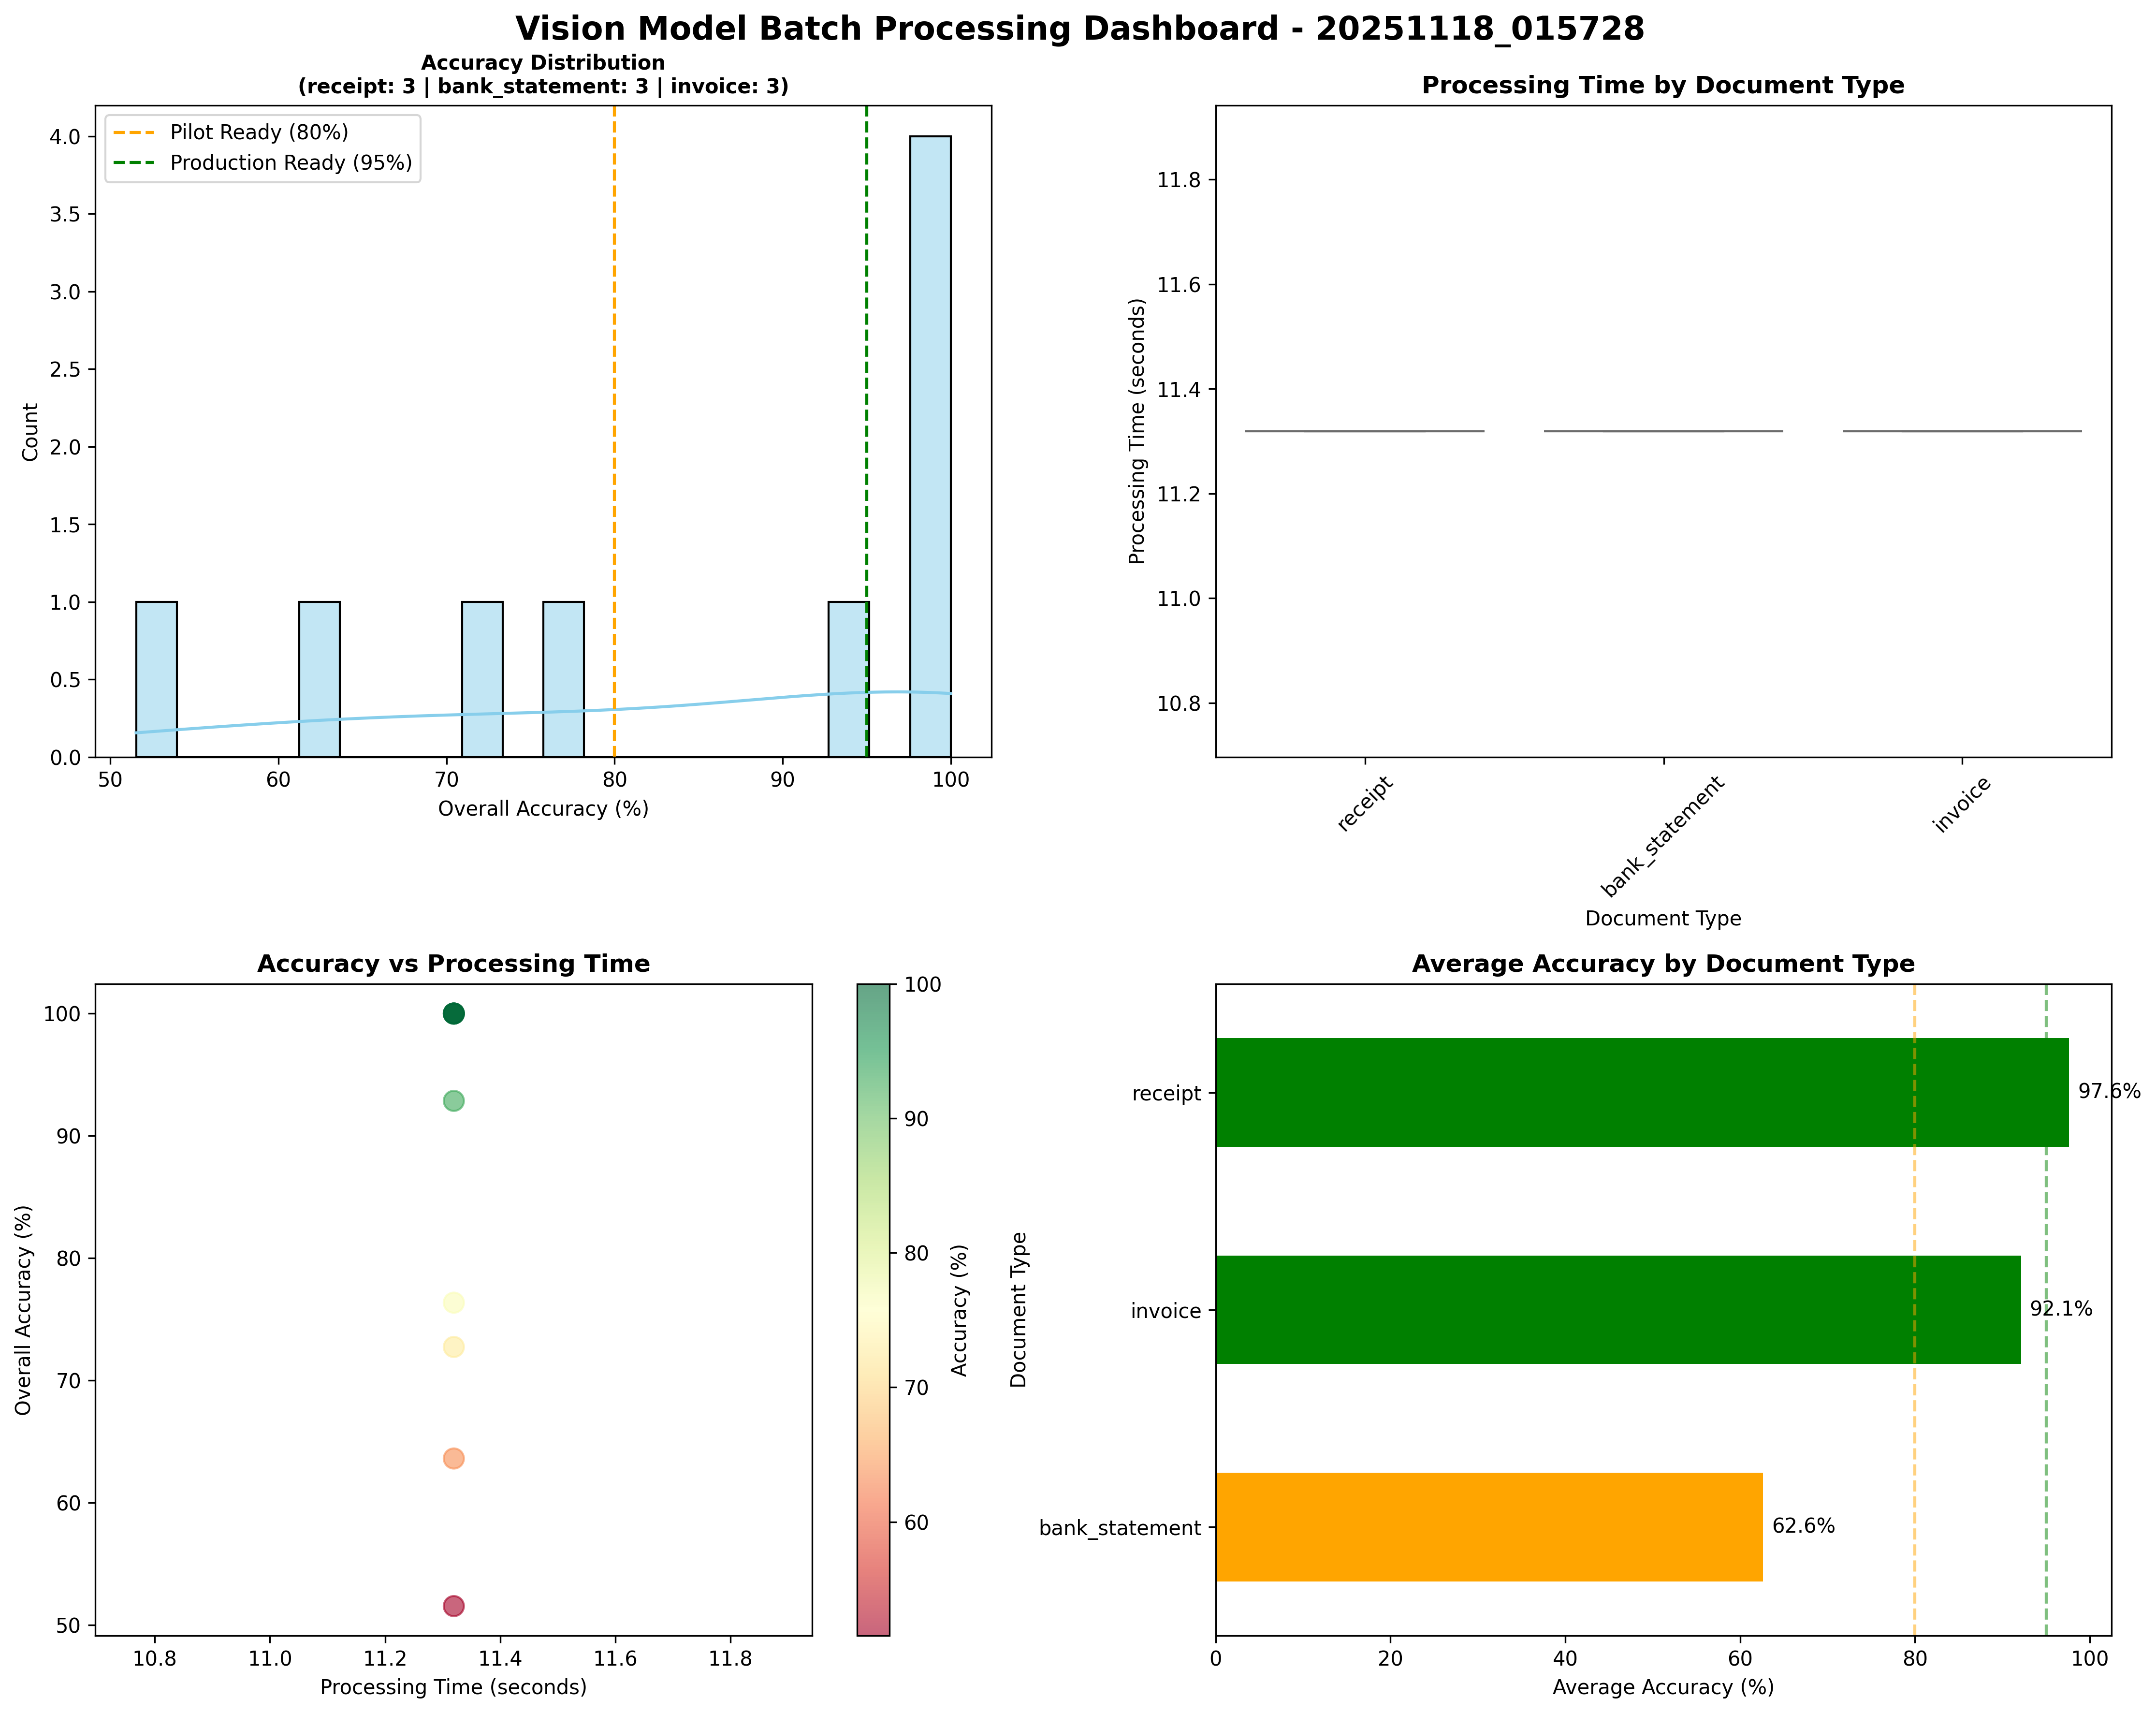

💡 Hot-Reload Tips:

• Edit prompts: config/prompts.yaml

• Reload: prompt_manager.reload_config()

• Switch models: Change CONFIG['MODEL_NAME'] and rerun Section 5

• Change system mode: Edit CONFIG['SYSTEM_MODE'] (expert/precise/flexible/strict)

In [14]:
console.rule("[bold green]Processing Complete[/bold green]")

total_images = len(batch_results)
successful = len([r for r in batch_results if 'error' not in r])

rprint(f"[bold green]✅ Processed: {total_images} images[/bold green]")
rprint(f"[cyan]Success Rate: {(successful/total_images*100):.1f}%[/cyan]")

if not CONFIG['INFERENCE_ONLY']:
    avg_accuracy = results_df['overall_accuracy'].mean() if 'overall_accuracy' in results_df else 0
    rprint(f"[cyan]Average Accuracy: {avg_accuracy:.2f}%[/cyan]")

rprint(f"[cyan]Model: {CONFIG['MODEL_NAME']}[/cyan]")
rprint(f"[cyan]System Mode: {CONFIG['SYSTEM_MODE']}[/cyan]")
rprint(f"[cyan]Output: {OUTPUT_BASE}[/cyan]")

# Display dashboard
dashboard_files = list(OUTPUT_DIRS['visualizations'].glob(f"dashboard_{BATCH_TIMESTAMP}.png"))
if dashboard_files:
    rprint("\n[bold blue]📊 Visual Dashboard:[/bold blue]")
    display(Image(str(dashboard_files[0])))

# Hot-reload info
rprint("\n[bold cyan]💡 Hot-Reload Tips:[/bold cyan]")
rprint("  • Edit prompts: config/prompts.yaml")
rprint("  • Reload: prompt_manager.reload_config()")
rprint("  • Switch models: Change CONFIG['MODEL_NAME'] and rerun Section 5")
rprint("  • Change system mode: Edit CONFIG['SYSTEM_MODE'] (expert/precise/flexible/strict)")

## 13. Zero Accuracy Analysis (Evaluation Mode Only)

In [15]:
if not CONFIG['INFERENCE_ONLY']:
    zero_accuracy_count = 0
    zero_accuracy_images = []
    total_evaluated = 0
    
    for result in batch_results:
        evaluation = result.get('evaluation', {})
        if evaluation and not evaluation.get('inference_only', False):
            total_evaluated += 1
            accuracy = evaluation.get('overall_accuracy', 0)
            
            if accuracy == 0.0:
                zero_accuracy_count += 1
                zero_accuracy_images.append({
                    'image_name': result.get('image_name', 'unknown'),
                    'document_type': result.get('document_type', 'unknown'),
                    'fields_extracted': evaluation.get('fields_extracted', 0),
                    'total_fields': evaluation.get('total_fields', 0),
                })
    
    console.rule("[bold red]Zero Accuracy Analysis[/bold red]")
    rprint(f"[cyan]Total documents evaluated: {total_evaluated}[/cyan]")
    rprint(f"[red]Documents with 0% accuracy: {zero_accuracy_count}[/red]")
    
    if zero_accuracy_count > 0:
        percentage = (zero_accuracy_count / total_evaluated) * 100
        rprint(f"[red]Zero accuracy rate: {percentage:.1f}%[/red]")
        rprint("\n[bold red]Documents with 0% Accuracy:[/bold red]")
        for i, img_info in enumerate(zero_accuracy_images, 1):
            rprint(f"  {i}. {img_info['image_name']} ({img_info['document_type']})")
            rprint(f"     Fields: {img_info['fields_extracted']}/{img_info['total_fields']}")
    else:
        rprint("[green]✅ No documents with 0% accuracy - all extractions had some success![/green]")
else:
    rprint("[yellow]⚠️ Zero accuracy analysis requires evaluation mode[/yellow]")

───────────────────────────────────────────── Zero Accuracy Analysis ──────────────────────────────────────────────

Total documents evaluated: 9

Documents with 0% accuracy: 0

✅ No documents with 0% accuracy - all extractions had some success!